# LightGBM Interpretability with ShAP

LightGBM offers a scalable solution that accomodates tabular and categorical inputs out of the box. 

### Setup

In [1]:
# Extension reloader to import a function again when re-running cell 
%load_ext autoreload
%autoreload 2

### Load Configuration

In [2]:
"""
Loads common configuration parameters
"""
import utils.configuration_manager as configuration_manager
from pathlib import PurePath
from os import getcwd

config_path = PurePath(getcwd(),'config.ini')
config = configuration_manager.Config(config_path)

# Assumes parquet directory as input
input_path = config.input_path
print('Input path: '+ input_path)

# For result storage
output_directory = config.output_directory
print('Output path: ' + output_directory)

Loading configuration from: /home/justin/Code/interpretability_experiment/config.ini
Input path: data/2018_Yellow_Taxi_Trip_Data_float64
Output path: output


### Start local Dask Client

In [3]:
from dask.distributed import Client, LocalCluster
try:
    if client:
        print('Restarting client')
        client.restart()
except:
#     cluster = LocalCluster(dashboard_address=':20100', memory_limit='4G')
    cluster = LocalCluster(dashboard_address=':20100')
    print('Setting new client')
    client = Client(cluster)
    print(client)
client

Setting new client
<Client: 'tcp://127.0.0.1:41149' processes=5 threads=10, memory=25.61 GB>


Client Scheduler: tcp://127.0.0.1:41149 Dashboard: http://127.0.0.1:20100/status,Cluster Workers: 5 Cores: 10 Memory: 25.61 GB


### Dask dataframe loader

In [4]:
import dask.dataframe as dd
import fastparquet

In [5]:
ddf = dd.read_parquet(input_path)

In [6]:
ddf.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
index,,,,,,,,,,,,,,,,,
0,1,2018-12-03 09:58:01,2018-12-03 10:14:17,1.0,1.20,1,N,186,161,1,11.0,0.0,0.5,2.95,0.00,0.3,14.75
1,2,2018-12-03 09:41:32,2018-12-03 10:20:08,1.0,12.03,1,N,138,162,1,39.0,0.0,0.5,9.11,5.76,0.3,54.67
2,2,2018-12-03 08:54:36,2018-12-03 08:59:35,2.0,0.86,1,N,151,166,1,5.5,0.0,0.5,1.26,0.00,0.3,7.56
3,2,2018-12-03 09:02:08,2018-12-03 09:07:16,2.0,1.09,1,N,166,238,1,6.0,0.0,0.5,1.36,0.00,0.3,8.16
4,2,2018-12-03 09:10:10,2018-12-03 09:21:32,2.0,1.78,1,N,238,75,1,9.5,0.0,0.5,2.06,0.00,0.3,12.36


In [7]:
ddf.dtypes

VendorID                       category
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                     category
store_and_fwd_flag               object
PULocationID                   category
DOLocationID                   category
payment_type                   category
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
dtype: object

In [8]:
%time len(ddf)

CPU times: user 1.09 s, sys: 115 ms, total: 1.2 s
Wall time: 8.88 s


112234626

### Define what we are trying to model

Let's try to create an estimator for the passenger tip, which I suspect is something pretty difficult to guess outright. 

Then we can look into other questions like whether the passenger count might affect the tip as a kind of social pressure. 

In [9]:
columns = [x for x in ddf.columns.values]
print(columns)

['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']


In [10]:
# Note - total_amount is excluded from the input list 
input_columns = ['VendorID', 
                 'passenger_count', 'trip_distance', 'RatecodeID', 
                 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
                 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'total_amount_wo_tip']

In [11]:
target = 'tip_amount'

In [12]:
"""
We'll subtract the tip_amount from the total_amount to prevent any leakage, 
using a new total_amount_wo_tip column.
"""
ddf['total_amount_wo_tip'] = ddf['total_amount'] - ddf['tip_amount']

## Form a manageable dataset in Pandas

In [13]:
from dask_ml.model_selection import train_test_split

ts = 'tpep_pickup_datetime'

/home/justin/.conda/envs/ml_env/lib/python3.7/site-packages/dask/array/random.py:27: FutureWarning: dask.array.random.doc_wraps is deprecated and will be removed in a future version
  FutureWarning,


In [14]:
partition_total = ddf.npartitions

In [15]:
train_size = int(partition_total/3)
test_size = int(partition_total - train_size)
print('Training partitions: ' + str(train_size))
print(test_size + train_size)

Training partitions: 108
326


In [16]:
from utils.helpful_functions import concatenate

columns_to_keep = input_columns + [target]

dfs = []

# Load and append to Pandas dataframe
for i in range(40):
    ddf_partition = ddf[columns_to_keep].get_partition(i)
    df_temp = ddf_partition.compute()
    dfs.append(df_temp)

df_train = concatenate(dfs)

In [17]:
print(df_train.dtypes)

VendorID                 category
passenger_count           float64
trip_distance             float64
RatecodeID               category
PULocationID             category
DOLocationID             category
payment_type             category
fare_amount               float64
extra                     float64
mta_tax                   float64
tolls_amount              float64
improvement_surcharge     float64
total_amount_wo_tip       float64
tip_amount                float64
dtype: object


### LightGBM Model

In [18]:
print(df_train.shape)

(13768049, 14)


In [19]:
"""
LightGBM parameters
"""
import lightgbm as lgb

In [20]:
lgb_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'metric': {'l2'},
    'num_leaves': 50,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'verbose': None,
    'max_depth':12,
    'min_data_in_leaf':100,
    'alpha':0.5}

def train_model(df_block):
    X = df_block[input_columns]
    print('Training with: ' + str(X.columns.values))
    y = df_block[target]
    print('Target is: ' + str(y.values))
    
    # Make training and validation sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.8)
    
#     # Transform to pandas dataframe for LightGBM support 
#     X_train, X_test, y_train, y_test = pandafy(X_train, X_test, y_train, y_test)
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test)

    #https://www.kaggle.com/mlisovyi/beware-of-categorical-features-in-lgbm
    # https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
    lgb_model = lgb.train(lgb_params,
                          lgb_train,
                          num_boost_round=300,
                          valid_sets=lgb_eval,
                          early_stopping_rounds=30)
    return lgb_model



In [21]:
lightgbm_model = train_model(df_train)

Training with: ['VendorID' 'passenger_count' 'trip_distance' 'RatecodeID' 'PULocationID'
 'DOLocationID' 'payment_type' 'fare_amount' 'extra' 'mta_tax'
 'tolls_amount' 'improvement_surcharge' 'total_amount_wo_tip']
Target is: [2.95 9.11 1.26 ... 2.   1.   0.  ]
[1]	valid_0's l2: 6.92275
Training until validation scores don't improve for 30 rounds
[2]	valid_0's l2: 6.83048
[3]	valid_0's l2: 6.78031
[4]	valid_0's l2: 6.69007
[5]	valid_0's l2: 6.64211
[6]	valid_0's l2: 6.55474
[7]	valid_0's l2: 6.46912
[8]	valid_0's l2: 6.42586
[9]	valid_0's l2: 6.34247
[10]	valid_0's l2: 6.26071
[11]	valid_0's l2: 6.21811
[12]	valid_0's l2: 6.17632
[13]	valid_0's l2: 6.09847
[14]	valid_0's l2: 6.02175
[15]	valid_0's l2: 5.94672
[16]	valid_0's l2: 5.8759
[17]	valid_0's l2: 5.80352
[18]	valid_0's l2: 5.73475
[19]	valid_0's l2: 5.66496
[20]	valid_0's l2: 5.59702
[21]	valid_0's l2: 5.53132
[22]	valid_0's l2: 5.46591
[23]	valid_0's l2: 5.4015
[24]	valid_0's l2: 5.33862
[25]	valid_0's l2: 5.27705
[26]	valid_0'

### Evaluating the model

In [22]:
df_test = ddf[columns_to_keep].get_partition(train_size + 1).compute()
df_test.reset_index(inplace=True)

In [23]:
import numpy as np

In [24]:
predicted = lightgbm_model.predict(df_test[input_columns])

In [25]:
actual = np.array(df_test['tip_amount'])

In [26]:
"""
Calculate mean absolute and squared error
"""
print('Mean absoluted error: ' + str(abs((actual - predicted)).mean(axis=0)))
print('Mean squared error: ' + str(((actual - predicted)**2).mean(axis=0)))

Mean absoluted error: 0.5984657629222175
Mean squared error: 1.6699114362203566


In [27]:
"""
Sanity check comparing the models results to simply guessing the mean
"""
tip_mean = df_train[target].mean()
print('The mean tip given is: ' + str(tip_mean))
tip_std = df_train[target].std()
print('The standard deviation of tips is: ' + str(tip_mean))

mean_array = np.full(len(actual),tip_mean ,dtype=float)
print('Mean absoluted error: ' + str(abs((mean_array - predicted)).mean(axis=0)))
print('Mean squared error: ' + str(((mean_array - predicted)**2).mean(axis=0)))

The mean tip given is: 1.8898131434598062
The standard deviation of tips is: 1.8898131434598062
Mean absoluted error: 1.275872891728823
Mean squared error: 4.017739763764305


The model is clearly learning something here

### Try built-in explainer

Now we'll take a look at possible contributors to the final tip received. Importantly, these will not tell you the direction of the relationship and cannot be taken at face value.

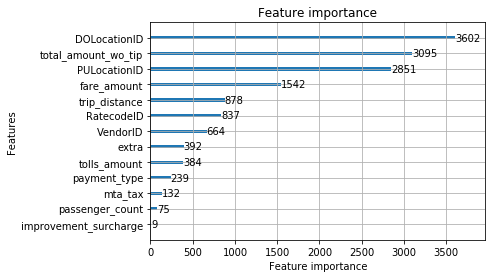

In [28]:
# Default feature importance is "split" which represents the number of times the feature is used by the model
lgb.plot_importance(lightgbm_model)

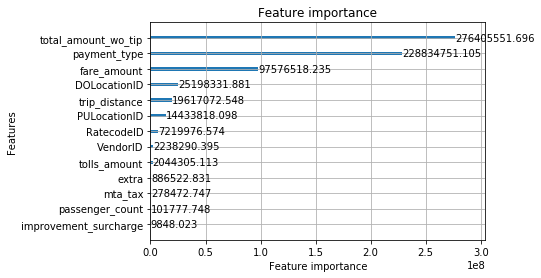

In [29]:
# Gain feature importance contains the total information gain the model has by using this feature
lgb.plot_importance(lightgbm_model, importance_type="gain")

Looking at whether we are plotting importance by the number of times the feature is used by the model (1st case) or the information gained by the use of a particular branch point (second case) we get pretty different results. 

Readings:
Interpretability with XGBoost
https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27

For census data and XGBoost:
https://slundberg.github.io/shap/notebooks/Census%20income%20classification%20with%20XGBoost.html

It seems like pick-up and drop-off location seem to be strong predictors, but we might have to control for the distance. 


### Payment-type exploration

Payment_type from feature importance derived by 'gain' seems promising. Let's investigate. 

In [30]:
"""
A numeric code signifying how the passenger paid for the trip.
1= Credit card
2= Cash
3= No charge
4= Dispute
5= Unknown
6= Voided trip
"""

'\nA numeric code signifying how the passenger paid for the trip.\n1= Credit card\n2= Cash\n3= No charge\n4= Dispute\n5= Unknown\n6= Voided trip\n'

In [31]:
# For local dataset
print(df_train['payment_type'].value_counts())

1    9497788
2    4177472
3      70422
4      22367
Name: payment_type, dtype: int64


In [32]:
# For global dataset
print(ddf['payment_type'].value_counts().compute())

1    77928307
2    33556849
3      582599
4      166868
5           3
Name: payment_type, dtype: int64


It's possible that 'no-charge' in this case guaranties no-tip, but that isn't a particularly useful finding. Perhaps we should remove this from the training set.

### Use SHAP explainer

In [33]:
import shap
shap.initjs() 

In [34]:
explainer = shap.TreeExplainer(lightgbm_model)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [35]:
print(len(df_test))

344118


In [36]:
samples = df_test[input_columns]#.sample(100000, random_state=42)

In [37]:
target_actual = df_test[target]#.sample(100000, random_state=42)

In [38]:
samples.head()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,total_amount_wo_tip
0,1,1.0,0.60,1,236,236,2,5.0,0.0,0.5,0.0,0.3,5.8
1,1,1.0,7.00,1,13,140,1,24.0,0.0,0.5,0.0,0.3,24.8
2,2,2.0,1.08,1,233,140,2,6.5,0.0,0.5,0.0,0.3,7.3
3,2,2.0,8.80,1,140,49,1,31.5,0.0,0.5,0.0,0.3,32.3
4,1,1.0,0.50,1,263,262,1,4.0,0.0,0.5,0.0,0.3,4.8


In [39]:
shap_values = explainer.shap_values(samples)

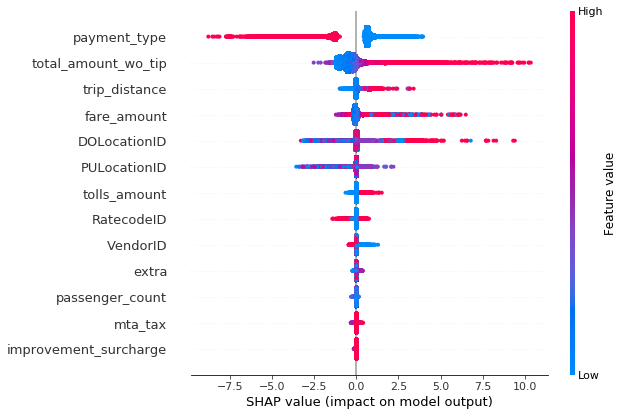

In [40]:
shap.summary_plot(shap_values,
                  samples)

In [ ]:
# shap.summary_plot(shap_values, X_importance, plot_type='bar')

In [45]:
# TODO compared summary to logistic regression weights for the same test set

## ShAP interactions

In [ ]:
X_interaction = X_importance.iloc[:500,:]
shap_interaction_values = shap.TreeExplainer(lgb_model).shap_interaction_values(X_interaction)

In [ ]:
shap_interaction_values = shap.TreeExplainer(lgb_model).shap_interaction_values(X_interaction)

### Extract features list 

In [ ]:
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

### Dependence Plots

To evaluate feature importance of our categorical features in more detail, we can look at scatter plots highlighting their individual contributions to the model predictions

In [41]:
# Understanding output: https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a

In [42]:
# shap.dependence_plot?

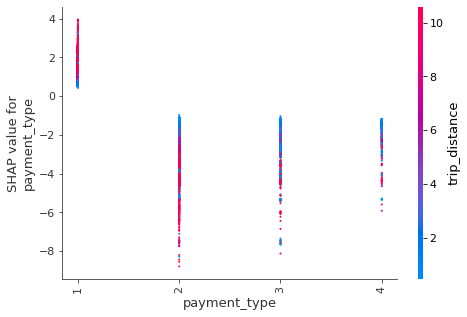

In [52]:
"""
Plots the value of the feature on the x-axis and the SHAP value of the same feature
on the y-axis. This shows how the model depends on the given feature, and is like a
richer extenstion of the classical parital dependence plots. Vertical dispersion of the
data points represents interaction effects. Grey ticks along the y-axis are data
points where the feature's value was NaN.
"""
feature_names = ['Credit card', \
              'Cash',\
              'No charge', \
              'Dispute']

shap.dependence_plot("payment_type", 
                     shap_values, 
                     samples, 
                     dot_size = 4,
                    interaction_index='trip_distance'
                    )

It's very possible here that credit card increased the likelihood the tip was reported 

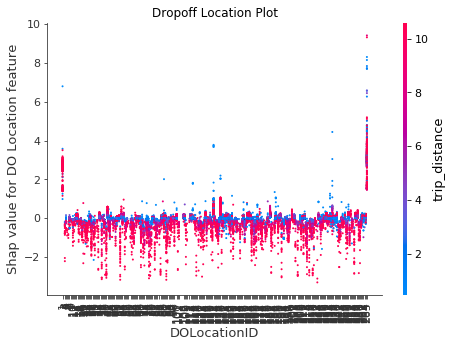

<Figure size 1440x7200 with 0 Axes>

In [47]:
import matplotlib.pyplot as plt

# from pylab import rcParams
# rcParams['figure.figsize'] = 20, 10

# %matplotlib inline
shap.dependence_plot("DOLocationID", 
                     shap_values, 
                     samples, 
#                      xmin="percentile(1)",
                     dot_size = 4,
                     show=False)

plt.title("Dropoff Location Plot")
plt.ylabel("Shap value for DO Location feature")
# plt.savefig("dropoff_location_dependency.pdf") # we can save a PDF of the figure if we want
plt.show()

## Unpacking a single example

In [94]:
i = 3

In [95]:
print(samples.iloc[i])

VendorID                    1
passenger_count             1
trip_distance             1.8
RatecodeID                  1
PULocationID              237
DOLocationID              164
payment_type                1
fare_amount              12.5
extra                       0
mta_tax                   0.5
tolls_amount                0
improvement_surcharge     0.3
total_amount_wo_tip      13.3
Name: 298724, dtype: object


In [96]:
print(target_actual.iloc[i])

2.65


In [108]:
# TODO map Feature to actual properties
shap.force_plot(explainer.expected_value, shap_values[i])#, feature_names=samples.columns.names)

In [53]:
# shap.force_plot?